In [1]:
import torch
import torchvision
from torchvision.datasets import MNIST

# 1. Download data

In [2]:
# Download training dataset
dataset = MNIST(root='data/', download=True)

9913344it [00:02, 3859725.35it/s]                             


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



29696it [00:00, 26216386.36it/s]         


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



1649664it [00:00, 3666137.16it/s]                             


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



5120it [00:00, 5318186.35it/s]          

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
len(dataset)

60000

In [4]:
test_dataset = MNIST(root='data/', train=False)
len(test_dataset)

10000

# 2. Display example

Label: 5


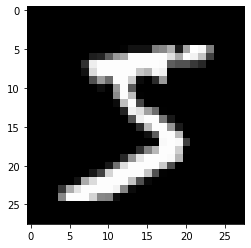

In [5]:
import matplotlib.pyplot as plt

image, label = dataset[0]
plt.imshow(image, cmap='gray')
print('Label:', label)

# 3. Convert data to tensor

In [6]:
import torchvision.transforms as transforms

# MNIST dataset (images and labels)
dataset = MNIST(root='data/', 
                train=True,
                transform=transforms.ToTensor())

In [7]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


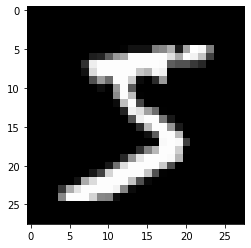

In [10]:
plt.imshow(img_tensor[0,:,:], cmap='gray')

# 4. Training and Validation Datasets

In [11]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

In [12]:
from torch.utils.data import DataLoader

batch_size = 128
# LOAD DATA BY BATCH SIZE
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

# 5. Model

In [13]:
import torch.nn as nn

input_size = 28*28
num_classes = 10

class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
model = MnistModel()

In [14]:
model.linear

Linear(in_features=784, out_features=10, bias=True)

In [15]:
print(model.linear.weight.shape, model.linear.bias.shape)

torch.Size([10, 784]) torch.Size([10])


In [16]:
for images, labels in train_loader:
    print(images.shape)
    outputs = model(images)
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

torch.Size([128, 1, 28, 28])
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.0674,  0.0495, -0.0433, -0.1925,  0.1481,  0.2398, -0.0923,  0.1729,
         -0.0994, -0.3464],
        [ 0.0572,  0.1747,  0.0991,  0.0243,  0.0672,  0.1954,  0.1886,  0.1473,
         -0.2100, -0.0346]])


In [20]:
torch.sum(outputs[0]).item()

-0.09609523415565491

# 6. Softmax

In [17]:
import torch.nn.functional as F

# Apply softmax for each output row
probs = F.softmax(outputs, dim=1)
# Look at sample probabilities
print("Sample probabilities:\n", probs[:2].data)
# Add up the probabilities of an output row
print("Sum: ", torch.sum(probs[0]).item())

Sample probabilities:
 tensor([[0.1065, 0.1046, 0.0953, 0.0821, 0.1154, 0.1265, 0.0908, 0.1183, 0.0901,
         0.0704],
        [0.0980, 0.1102, 0.1022, 0.0948, 0.0990, 0.1125, 0.1117, 0.1072, 0.0750,
         0.0894]])
Sum:  1.0000001192092896


In [22]:
max_probs, preds = torch.max(probs, dim=1)
print(preds[:2])
print(max_probs[:2])

tensor([5, 5])
tensor([0.1265, 0.1125], grad_fn=<SliceBackward0>)


# 7. Evaluate

In [25]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [24]:
accuracy(outputs, labels)

tensor(0.1250)

# 8. Loss function

In [26]:
loss_fn = F.cross_entropy

# Loss for current batch of data
loss = loss_fn(outputs, labels)
print(loss)

tensor(2.2981, grad_fn=<NllLossBackward0>)


# 9. Train model

In [28]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()

In [29]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [30]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results
    
    for epoch in range(epochs):
        
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [31]:
history1 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9740, val_acc: 0.6160
Epoch [1], val_loss: 1.7010, val_acc: 0.7119
Epoch [2], val_loss: 1.4969, val_acc: 0.7479
Epoch [3], val_loss: 1.3428, val_acc: 0.7706
Epoch [4], val_loss: 1.2242, val_acc: 0.7874


In [32]:
history2 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.1311, val_acc: 0.7985
Epoch [1], val_loss: 1.0565, val_acc: 0.8078
Epoch [2], val_loss: 0.9954, val_acc: 0.8152
Epoch [3], val_loss: 0.9446, val_acc: 0.8205
Epoch [4], val_loss: 0.9017, val_acc: 0.8246


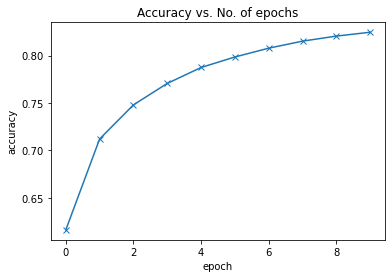

In [33]:
history = history1 + history2
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

# 10. Testing with individual images

In [34]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=transforms.ToTensor())

Shape: torch.Size([1, 28, 28])
Label: 7


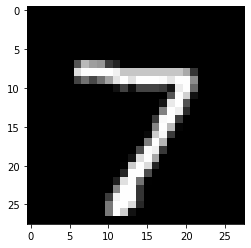

In [35]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Shape:', img.shape)
print('Label:', label)

In [36]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

Label: 7 , Predicted: 7


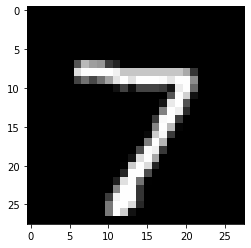

In [37]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 0 , Predicted: 0


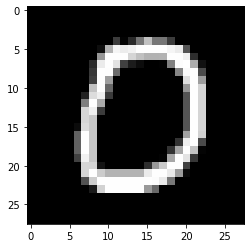

In [38]:
img, label = test_dataset[10]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [39]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model, test_loader)
result

{'val_loss': 0.8692982792854309, 'val_acc': 0.8360351324081421}

# 11. Save load model

In [41]:
# SAVE MODEL
torch.save(model.state_dict(), 'mnist-logistic.pth')

In [42]:
# The .state_dict method returns an OrderedDict 
# containing all the weights and bias matrices 
# mapped to the right attributes of the model.
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0183,  0.0320, -0.0050,  ..., -0.0294,  0.0187, -0.0283],
                      [ 0.0291, -0.0082, -0.0338,  ..., -0.0302, -0.0270, -0.0146],
                      [ 0.0009,  0.0024,  0.0162,  ...,  0.0320, -0.0185, -0.0133],
                      ...,
                      [ 0.0339,  0.0165, -0.0217,  ..., -0.0191, -0.0107,  0.0029],
                      [ 0.0085, -0.0342, -0.0286,  ..., -0.0237, -0.0116,  0.0254],
                      [-0.0334,  0.0224,  0.0256,  ..., -0.0165, -0.0031,  0.0339]])),
             ('linear.bias',
              tensor([-0.0157,  0.0610, -0.0048, -0.0039,  0.0128,  0.0335, -0.0010,  0.0216,
                      -0.0212,  0.0207]))])

In [43]:
model2 = MnistModel()
# Load weight, bias
model2.load_state_dict(torch.load('mnist-logistic.pth'))
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0183,  0.0320, -0.0050,  ..., -0.0294,  0.0187, -0.0283],
                      [ 0.0291, -0.0082, -0.0338,  ..., -0.0302, -0.0270, -0.0146],
                      [ 0.0009,  0.0024,  0.0162,  ...,  0.0320, -0.0185, -0.0133],
                      ...,
                      [ 0.0339,  0.0165, -0.0217,  ..., -0.0191, -0.0107,  0.0029],
                      [ 0.0085, -0.0342, -0.0286,  ..., -0.0237, -0.0116,  0.0254],
                      [-0.0334,  0.0224,  0.0256,  ..., -0.0165, -0.0031,  0.0339]])),
             ('linear.bias',
              tensor([-0.0157,  0.0610, -0.0048, -0.0039,  0.0128,  0.0335, -0.0010,  0.0216,
                      -0.0212,  0.0207]))])

In [44]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model2, test_loader)
result

{'val_loss': 0.8692982792854309, 'val_acc': 0.8360351324081421}